<h1><center>Análisis de impacto Incendio Viña del Mar, Febrero 2024 </center></h1>
<h2><center>Min Soo Jeon, Roberto Benatuil y Diego Larraguibel</center></h2>

En el marco de los incendios ocurridos durante el mes de Febrero en la quinta región de Chile, nos proponemos comparar la vegetación previa y posterior al incendio. Para esto, se utilizará el índice NDVI.

## Importación, carga y procesamiento de los datos

In [59]:
import googlemaps
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import geemap
import datetime
import numpy as np

In [13]:
import ee
# ee.Authenticate()
ee.Initialize()

In [25]:
comunas = gpd.read_file('Comunas_chile/comunas.shp')
comunas = comunas.to_crs('EPSG:4326')
comunas_deseadas = ['Valparaíso', 'Viña del Mar']
zone = comunas[comunas['Comuna'].isin(comunas_deseadas)].envelope

<Axes: >

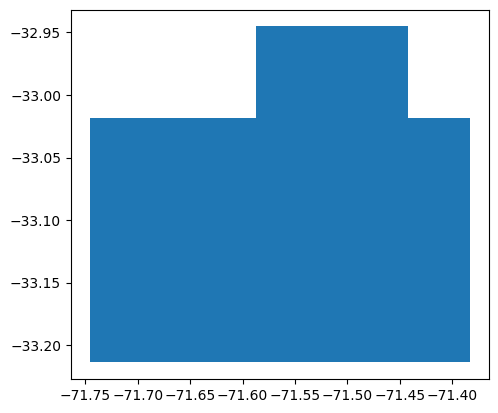

In [26]:
zone.plot()

In [63]:
poly = zone.geometry.iloc[0]
xy = list(poly.exterior.coords)
aoi = ee.Geometry.Polygon(xy)

## Visualización preliminar

In [64]:
collection = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(aoi).filterDate('2024-02-01', '2024-02-14')
images=collection.aggregate_array('system:id').getInfo()

In [65]:
images

['COPERNICUS/S2_SR/20240202T143741_20240202T144513_T18HYJ',
 'COPERNICUS/S2_SR/20240202T143741_20240202T144513_T19HBD',
 'COPERNICUS/S2_SR/20240207T143739_20240207T144509_T18HYJ',
 'COPERNICUS/S2_SR/20240207T143739_20240207T144509_T19HBD',
 'COPERNICUS/S2_SR/20240212T143741_20240212T144410_T18HYJ',
 'COPERNICUS/S2_SR/20240212T143741_20240212T144410_T19HBD']

In [66]:
# Define a function to convert Unix timestamps to human-readable dates
def unix_timestamp_to_date(timestamp):
    return datetime.datetime.utcfromtimestamp(timestamp / 1000)

In [78]:
features = collection.getInfo()['features']
dates = []
for f in features:
    image_date_timestamp = f['properties']['system:time_start']
    image_date = unix_timestamp_to_date(image_date_timestamp)
    print('Image ID:', f['id'])
    print('Image Date:', str(image_date).split(" ")[0])
    dates.append(str(image_date).split(" ")[0])

Image ID: COPERNICUS/S2_SR/20240202T143741_20240202T144513_T18HYJ
Image Date: 2024-02-02
Image ID: COPERNICUS/S2_SR/20240202T143741_20240202T144513_T19HBD
Image Date: 2024-02-02
Image ID: COPERNICUS/S2_SR/20240207T143739_20240207T144509_T18HYJ
Image Date: 2024-02-07
Image ID: COPERNICUS/S2_SR/20240207T143739_20240207T144509_T19HBD
Image Date: 2024-02-07
Image ID: COPERNICUS/S2_SR/20240212T143741_20240212T144410_T18HYJ
Image Date: 2024-02-12
Image ID: COPERNICUS/S2_SR/20240212T143741_20240212T144410_T19HBD
Image Date: 2024-02-12


In [95]:
Map = geemap.Map()
p = aoi.centroid()
Map.centerObject(p, 14)

rgb = ['B4','B3','B2']
rgbViz = {"min": 0.0, "max": 6000, "bands": rgb}
inf = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}

for i, photo in enumerate(images):
    image=ee.Image(photo)
    clipped_image = image.clip(aoi)
    Map.addLayer(clipped_image, rgbViz, f'RGB ({dates[i]})')


In [69]:
Map

Map(center=[-33.11610627374921, -71.56456817471683], controls=(WidgetControl(options=['position', 'transparent…

In [113]:
before_fire = images[1]
after_fire = images[5]
relevant_images = [before_fire, after_fire]
relevant_dates = ["02-02", "02-12"]
green_mask_param = 0.25

Map = geemap.Map()
p = aoi.centroid()
Map.centerObject(p, 12)

rgb = ['B4','B3','B2']
rgbViz = {"min": 0.0, "max": 6000, "bands": rgb}
inf1 = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'red']}
inf2 = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}

im1 = ee.Image(before_fire)
clipped_image1 = im1.clip(aoi)
ndvi1 = clipped_image1.normalizedDifference(['B8A', 'B4'])
ndvi = ndvi1.clip(aoi)
red_mask = ndvi1.gt(green_mask_param).selfMask()
Map.addLayer(clipped_image1, rgbViz, f'RGB ({relevant_dates[0]})')
# Map.addLayer(ndvi1, inf2, f'NDVI ({dates[i]})')
Map.addLayer(red_mask, inf1, f'NDVI > {green_mask_param} ({relevant_dates[0]})')


im2 = ee.Image(after_fire)
clipped_image2 = im2.clip(aoi)
ndvi2 = clipped_image2.normalizedDifference(['B8A', 'B4'])
ndvi2 = ndvi2.clip(aoi)
green_mask = ndvi2.gt(green_mask_param).selfMask()
# Map.addLayer(ndvi2, inf2, f'NDVI ({relevant_dates[i]})')
# Map.addLayer(clipped_image2, rgbViz, f'RGB ({relevant_dates[1]})')
Map.addLayer(green_mask, inf2, f'NDVI > {green_mask_param} ({relevant_dates[1]})')

Map

Map(center=[-33.11610627374921, -71.56456817471683], controls=(WidgetControl(options=['position', 'transparent…

In [114]:
pixel_area = ee.Image.pixelArea()
burnt_area = red_mask.multiply(pixel_area).reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi, scale=10).getInfo()['nd']
# Multimplicamos los pixeles de la green_mask por el área del pixel y sumamos. Utilizamos escala 10, dado que es la resolución de sentinel2.

green_area = green_mask.multiply(pixel_area).reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi, scale=10).getInfo()['nd']
burnt_ratio = round(green_area / burnt_area, 2)
print(f'El porcentaje de zonas quemadas, respecto a las zonas verdes totales (NDVI >= {green_mask_param}) es: ', round(1 - burnt_ratio, 2))

El porcentaje de zonas quemadas, respecto a las zonas verdes totales (NDVI >= 0.25) es:  0.12


Cabe considerar que este valor considera gran parte de cerros. El porcentaje de vegetacion en zonas habitadas 
será evidentemente mayor. A continuación visualizaremos las zonas verdes repartidas por la comuna.

In [40]:
Map


Map(center=[-33.11610627374921, -71.56456817471683], controls=(WidgetControl(options=['position', 'transparent…

# 5.5

(No logrado)

In [134]:
col = ['geometry', 'min_dist_hospital', 'min_dist_educacion_primaria', 'min_dist_zona_verde', 'min_dist_transporte_publico']
reina_filter = manz_reina[col]
rf = reina_filter[['geometry', 'min_dist_hospital']]

In [166]:
import folium

mapa = folium.Map(location=[reina_filter.geometry.centroid.y.mean(), reina_filter.geometry.centroid.x.mean()], zoom_start=12)
folium.Choropleth(
    geo_data=reina_filter,
    data=reina_filter,
    columns=['geometry','min_dist_hospital'],
    key_on='feature.id',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Legend',
).add_to(mapa)

ValueError: All values are expected to fall into one of the provided bins (or to be Nan). Please check the `bins` parameter and/or your data.

In [167]:
m

Por motivos que desconozco, mi choropleth no permite visualizar los colores 

### 5.6 Análisis y conclusiones [5 puntos].

Analice los resultados de su análisis y comente, ¿qué conclusiones puede obtener en relación al acceso a servicios públicos básicos y movilidad sustentable en su comuna de estudio? ¿A partir de los mapas generados, puede apreciar algún patrón o relación espacial relevante? 
Como complemento al mapa generado en el punto 5.5, escriba un texto de al menos 150 palabras resumiendo su análisis y conclusiones.


* Transporte: Como se remarca en el gráfico 'distancia mínima a transporte público en la Reina', la comuna se puede segmentar en dos zonas: por un lado, la zona poniente cuenta con gran conectividad, mientras que la zona oriente a penas posee estaciones de micro y metro. Para buscar causas de esto, podría ser interesante analizar densidad poblacional y factores socioeconómicos.

* Ciclovías: hay una cobertura del 8%, número que debe ser mejorado. Sin embargo, se rescata que la comuna cuenta con ciclovías en todas su calles principales. Es necesario comparar con otras comunas de santiago para afirmar si es un buen o mal porcentaje.

* Salud pública: Como se observa en el gráfico 'Distancia mínima a salud pública en la Reina', los centros se encuentran concentrados en la parte central de la comuna.

* Zonas verdes: Como observamos en 'Distancia mínima a zonas verdes en la Reina', hay una zona en la parte oriente de la comuna con mayor lejanía de zonas verdes. 


Para finalizar, destaco que la zona oriente se encuentra lejos de salud pública, educación básica gratuita y de transporte público.